<a href="https://colab.research.google.com/github/ParvinGhaffarzadeh/CNN_model/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import os
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
keras.__version__

'2.7.0'

In [3]:
# implement the progect with GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16221468425977684763
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12569889480539827177
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#unzip ALL_IDB dataset
!unzip "/content/drive/MyDrive/ALL_IDB.zip"

Archive:  /content/drive/MyDrive/ALL_IDB.zip
   creating: ALL_IDB/
   creating: ALL_IDB/ALL_IDB1/
   creating: ALL_IDB/ALL_IDB1/im/
  inflating: ALL_IDB/ALL_IDB1/im/Im001_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im002_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im003_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im004_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im005_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im006_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im007_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im008_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im009_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im010_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im011_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im012_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im013_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im014_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im015_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im016_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im017_1.jpg  
  inflating: ALL_IDB/ALL_IDB1/im/Im018_1.jpg  
  inflating: ALL_IDB/A

In [6]:
#make dataset folder and copy images to dataset folder
#split healthy(normal) from abnormal(blast) images:
#*_0.tif ==> normal image
#*_1.tif ==> blast image
!mkdir ./dataset
!mkdir ./dataset/normal
!cp ./ALL_IDB/ALL_IDB2/img/*_0.tif ./dataset/normal
!mkdir ./dataset/blast
!cp ./ALL_IDB/ALL_IDB2/img/*_1.tif ./dataset/blast

In [7]:
# counting normal and blast images
for label in ('normal', 'blast'):
  print(f"Number of images in {label} is: ", len(glob.glob(f"dataset/{label}/*.tif")))

Number of images in normal is:  130
Number of images in blast is:  130


In [8]:
# split train, test and validation set 
!pip install split-folders
import splitfolders
# 80% train =  80% pure train + 20% validation
# 20% test

# select train, test and validation images and move to MY_ALL_IDB dataset
splitfolders.ratio("dataset", output="My_ALL_IDB", seed=1234, ratio=(.64, .16, .2), group_prefix=None)
# 20% for test 80% for train and validation
#The number of images in each folder can be varied using the values in the ratio argument(train:val:test).


from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

# trainig batch size and the number of training set
bs_train = 4
it_train = datagen.flow_from_directory(
    'My_ALL_IDB/train', 
    class_mode='categorical', 
    batch_size=bs_train,
    shuffle=False
)

# test batch size and the number of test set
bs_test = 4
it_test = datagen.flow_from_directory(
    'My_ALL_IDB/test', 
    class_mode='categorical',
    batch_size=bs_test,
    shuffle=False
)
# validation batch size and the number of validation set
bs_val = 4
it_val = datagen.flow_from_directory(
    'My_ALL_IDB/val', 
    class_mode='categorical', 
    batch_size=bs_val,
    shuffle=False
)


Copying files: 260 files [00:00, 2178.73 files/s]


Found 166 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [10]:
# create CNN model and plot it
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
model = Sequential([
  Conv2D(filters=128, kernel_size=2, input_shape=(256,256,3), strides=1, activation="relu", padding="same"),
  MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),

  Conv2D(filters=64, kernel_size=2, input_shape=(128,128,3), strides=1, activation="relu", padding="same"),
  MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),

  Conv2D(filters=32, kernel_size=2, input_shape=(64,64,3), strides=1, activation="relu", padding="same"),
  MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),

  Conv2D(filters=16, kernel_size=2, input_shape=(32,32,3), strides=1, activation="relu", padding="same"),
  MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),

  Dense(50, activation="relu"),

  Flatten(),

  Dense(2, activation="softmax"),
])

loss = keras.losses.BinaryCrossentropy(from_logits=False)
opt = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer = opt,
    loss = loss,
    metrics = ['accuracy'],
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 128)     1664      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        8224      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)      

In [11]:
# Create a callback that saves the model's weights
checkpoint_path = "checkpoints/model.ckpt"
cp = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True, 
    save_weights_only = True, 
    verbose = 1
)


es = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 1, 
    patience = 20
)

In [12]:
# fit the model on dataset
history = model.fit(
    it_train, 
    steps_per_epoch=it_train.n // bs_train,
    validation_data=it_val,
    validation_steps=it_val.n // bs_val,
    epochs=25
)

Epoch 1/25
41/41 [==============================] - 12s 57ms/step - loss: 1.7573 - accuracy: 0.4568 - val_loss: 0.7202 - val_accuracy: 0.5250
Epoch 2/25
41/41 [==============================] - 2s 45ms/step - loss: 0.6999 - accuracy: 0.5988 - val_loss: 1.0425 - val_accuracy: 0.5000
Epoch 3/25
41/41 [==============================] - 2s 46ms/step - loss: 0.7054 - accuracy: 0.6790 - val_loss: 1.5351 - val_accuracy: 0.5000
Epoch 4/25
41/41 [==============================] - 2s 45ms/step - loss: 0.9216 - accuracy: 0.5247 - val_loss: 0.5348 - val_accuracy: 0.7500
Epoch 5/25
41/41 [==============================] - 2s 53ms/step - loss: 0.5374 - accuracy: 0.7716 - val_loss: 0.4888 - val_accuracy: 0.7250
Epoch 6/25
41/41 [==============================] - 2s 44ms/step - loss: 0.4382 - accuracy: 0.7840 - val_loss: 0.5675 - val_accuracy: 0.7500
Epoch 7/25
41/41 [==============================] - 2s 45ms/step - loss: 0.7364 - accuracy: 0.6543 - val_loss: 0.4915 - val_accuracy: 0.6750
Epoch 8/25
4

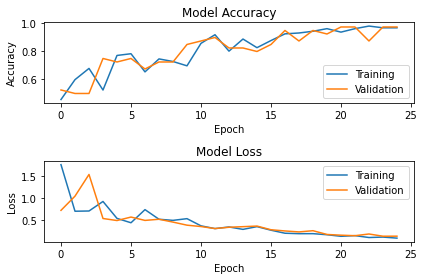

In [13]:
# plot train accuracy, train loss, test accurasy and test loss
plt.figure(1)
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()


In [14]:
score = model.evaluate(it_train, verbose=0)
print("Train accuracy: {:0.2f}%".format(score[1]*100))
print("Train loss: {:0.2f}".format(score[0]))

Train accuracy: 98.80%
Train loss: 0.07


In [15]:
score = model.evaluate(it_test, verbose=0)
print("Test accuracy: {:0.2f}%".format(score[1]*100))
print("Test loss: {:0.2f}".format(score[0]))

Test accuracy: 98.15%
Test loss: 0.12


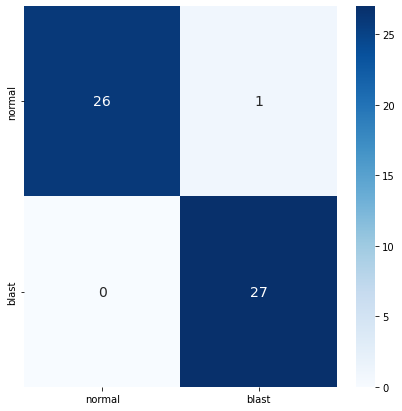

In [16]:
# plot confusion matrix
probabilities = model.predict(it_test)
y_pred = probabilities.argmax(axis=-1)
y_true = it_test.classes
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                     index = [i for i in ('normal', 'blast')],
                     columns = [i for i in ('normal', 'blast')])
                     
plt.figure(figsize = (7,7))
sn.heatmap(df_cm, fmt=".4g", annot=True, annot_kws={"size": 14}, cmap=plt.cm.Blues)
plt.show()

In [17]:
# show percision, recal and fscore for class 1 and class 2
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred)
print(f"[Test set precision] class_1: is {precision[0]:0.3f}, class_2 is: {precision[1]:0.3f}")
print(f"[Test set    recall] class_1: is {recall[0]:0.3f}, class_2 is: {recall[1]:0.3f}")
print(f"[Test set   f1score] class_1: is {fscore[0]:0.3f}, class_2 is: {fscore[1]:0.3f}")

[Test set precision] class_1: is 1.000, class_2 is: 0.964
[Test set    recall] class_1: is 0.963, class_2 is: 1.000
[Test set   f1score] class_1: is 0.981, class_2 is: 0.982
